In [1]:
import os
import os.path
import sys
import shutil
from pprint import pprint
from datetime import datetime
from copy import copy
from copy import deepcopy
import pickle

from parflowio.pyParflowio import PFData

import pandas as pd
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.image as mpimg
import matplotlib.cm as cm
import matplotlib.cbook as cbook
from matplotlib.path import Path
from matplotlib.patches import PathPatch

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import PowerTransformer

from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error
import glob


from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error


# -- Libararies  
import os
import sys
import pickle
import torch
from random import *

# for SBI
from sbi import utils as utils
from sbi import analysis as analysis
from sbi import inference
from sbi.inference.base import infer
from sbi.inference import SNPE, simulate_for_sbi, prepare_for_sbi
from sbi.types import Array, OneOrMore, ScalarFloat

from matplotlib import pyplot as plt

import numpy as np
from numpy import cov
from numpy.linalg import det, norm # determinant, norm (used to calculate 'euclidean' distance)

import random
from numpy.random import normal
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import matplotlib.tri as tri
import seaborn as sns
from seaborn import pairplot
from seaborn import jointplot
import pandas as pd
from parflowio.pyParflowio import PFData
# import pygmmis <- This was the default but it doesn't work very well
from sklearn.mixture import GaussianMixture as GMM
import sys
import os
from datetime import datetime

# for machine learning
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset # for refactoring x and y
from torch.utils.data import DataLoader # for batch submission
from torch.autograd import Variable
import torch.nn.functional as F
from torch.distributions import Independent, Uniform
from torch.distributions.log_normal import LogNormal

# for scaling
from sklearn.preprocessing import MinMaxScaler

# for stats
sys.path.append('/home/qh8373/SBI_TAYLOR/sbi_taylor/scripts/05_utils/')
from assessutils import compute_stats
import re
from scipy.stats import mode

# helpers
sys.path.append('/home/qh8373/SBI_TAYLOR/sbi_taylor/scripts/03_sbi_lstm/')
from sbi_build import simulate

# Path to the SandTank Repo
dev_path = '/home/SHARED/ML_TV/HydroGEN/modules/'
#Add Sand Tank path to the sys path
sys.path.append(dev_path)
from transform import float32_clamp_scaling

# user defined functions
sys.path.append('/home/qh8373/SBI_TAYLOR/sbi_taylor/scripts/05_utils/')
from genutils import PFread, plot_stuff
from ensembleutils import assembleYears, assembleAllForcings, parseAllMetadata, returnDF_ens, returnAOC_ens, _ret_MinMax, _ret_AOCMinMax
from assessutils import compute_stats
from scalerutils import scaled_ens_Values, scaledForcingData, scaledAOCData
from posteriorsamputils import statTheta, genProbThetas, gen_Fit_Series_Wrapper
from summaryutils import summary, setStatSim
from sbiutils import retStatTyp, parseListDf, parseUniqueParams
from sbiutils import reshape_y, createYHatList, createYHat
from interputils import *

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.image as mpimg
import matplotlib.cm as cm
import matplotlib.cbook as cbook
from matplotlib.path import Path
from matplotlib.patches import PathPatch
from matplotlib.colors import LogNorm, Normalize
import matplotlib.tri as tri
import pickle
import sys
import torch

import spotpy
import spotpy.objectivefunctions as obj_mets

import scipy
from scipy.spatial import distance

/home/SHARED/software/anaconda3/2020.07e/lib/python3.8/site-packages/setuptools/distutils_patch.py:25: UserWarning: Distutils was imported before Setuptools. This usage is discouraged and may exhibit undesirable behaviors or errors. Please use Setuptools' objects directly or at least import Setuptools first.
  warnings.warn(


In [2]:
# Directories
sbi_run  = '0819_01_mod2_02_05_lstm_A_0206_01_full_surrogate'
print(sbi_run)
sbi_dir = f'/home/qh8373/SBI_TAYLOR/data/05_sbi_out/{sbi_run}/'
save_dir = f'/home/qh8373/SBI_TAYLOR/data/06_interp_out/experiments/{sbi_run}/'
print(save_dir)

lstm_name = '02_05_lstm_A'
lstm_path = f'/home/qh8373/SBI_TAYLOR/data/04_lstm_out/{lstm_name}/'

# load lstm info
with open(lstm_path+'list_df_cond.pkl', 'rb') as fp:
    list_df_cond = pickle.load(fp)

0819_01_mod2_02_05_lstm_A_0206_01_full_surrogate
/home/qh8373/SBI_TAYLOR/data/06_interp_out/experiments/0819_01_mod2_02_05_lstm_A_0206_01_full_surrogate/


In [3]:
# Selection Criteria
sub = 0 # Posterior Sub (Lsim=0 to 10)
idx = 1 #PF:LSTM, 0=82, 1=83, .... #Observation
lstm_idx = 0 #LSTM number in ensemble, nb: should be the same idx as that used in inference = 0
n_samples = 5000 
sbi_dir_sub = f'{sbi_dir}{sub}/'

# load posterior
with open(sbi_dir_sub+'posterior.pkl', 'rb') as fp:
    posterior = pickle.load(fp)

In [4]:
'''
ParFlow truth loads
lstm_df_cond should be loaded
to test ParFlow truths on models trained with LSTMs and previous tested with LSTM synthetic truths
'''
DataX_test, DataY_test, series_len, lstm_out_list = parseListDf(list_df_cond)
test_params, num_params, num_unique, DataX_test = parseUniqueParams(DataX_test, series_len)


'''
Load up all those truths
'''
unique_series_PF = createYHatList(DataY_test, series_len, num_unique,
                stat_method='full', stat_typ=None, embed_type=None)
unique_series_full_PF = createYHatList(DataY_test, series_len, num_unique,
                    stat_method='full', stat_typ=None, embed_type=None)

'''
sample observation (y_hat) and 'correct' parameter (true_theta)
    y_hat_full is the full timeseries (important for embed and summary stat method)
'''
true_theta = test_params[idx]
print(true_theta)

tensor([0.5995, 0.8495])


/home/qh8373/SBI_TAYLOR/sbi_taylor/scripts/05_utils/sbiutils.py:110: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(y_out)


In [5]:
# emulated streamflow
y_hat_full = reshape_y(simulate(DataX=DataX_test, theta=true_theta, lstm=lstm_out_list[lstm_idx]))
y_hat = createYHat(y_hat_full, stat_method='full', stat_typ=None, embed_type=None)
y_hat_np = np.array(y_hat)

def _np_q_surrogate(DataX_test, true_theta, lstm_out_list, lstm_idx):
    y_hat_full = reshape_y(simulate(DataX=DataX_test, theta=true_theta, lstm=lstm_out_list[lstm_idx]))
    y_hat = createYHat(y_hat_full, stat_method='full', stat_typ=None, embed_type=None)
    y_hat_np = np.array(y_hat.clone().detach())
    return y_hat_np


In [6]:
# ParFlow streamflow
y_hat_PF = unique_series_PF[idx]
y_hat_full_PF = unique_series_full_PF[idx]
y_hat_PF_np = np.array(y_hat_PF)

def _np_q_PF(unique_series_PF, idx):
    y_hat_PF = unique_series_PF[idx]
    y_hat_PF_np = np.array(y_hat_PF.clone().detach())
    return y_hat_PF_np
    

In [7]:
# RMSE
nse_temp = obj_mets.nashsutcliffe(y_hat_PF_np, y_hat_np)
# NSE
rmse_temp = obj_mets.rmse(y_hat_PF_np, y_hat_np)
# kge, cc, alpha, beta
kge_temp = obj_mets.kge(y_hat_PF_np, y_hat_np, return_all=True)
print(nse_temp)
print(rmse_temp)
print(kge_temp)

def _metrics_fun(y_hat_PF_np, y_hat_np):
    kge_temp = obj_mets.kge(y_hat_PF_np, y_hat_np, return_all=True)
    
    met_dict = {'NSE'  : obj_mets.nashsutcliffe(y_hat_PF_np, y_hat_np),
                'RMSE' : obj_mets.rmse(y_hat_PF_np, y_hat_np), 
                'KGE'  : kge_temp[0],
                'cc'   : kge_temp[1],
                'alpha': kge_temp[2],
                'beta' : kge_temp[3]
               }
    
    return met_dict

out_met = _metrics_fun(y_hat_PF_np, y_hat_np)


0.9902380853891373
0.008784756
(0.9800881414104403, 0.9951961385724855, 0.9823685, 0.992092)


In [10]:
# Pseudocode

# create a dataframe for: parameters, 5 metrics
df_perf = pd.DataFrame(np.empty((len(test_params), 8)), columns = ['K','M']+list(out_met.keys()))


# loop through all idxs
for idin in range(len(test_params)):
    
    # extract y_hat from PF and np
    temp_theta = test_params[idin]
    temp_y_surr = _np_q_surrogate(DataX_test, temp_theta, lstm_out_list, lstm_idx)
    temp_y_PF = _np_q_PF(unique_series_PF, idin)
    
    # calculate metrics and put in array
    temp_met = _metrics_fun(temp_y_PF, temp_y_surr)
    
    # update df
    df_perf.iloc[idin] = list(temp_theta)+list(temp_met.values())
    
    del temp_theta, temp_y_surr, temp_y_PF, temp_met


# Compute CDF for each of 5 metrics (df[metric].rank(pct=True)
for met in list(out_met.keys()): 
    df_perf[f'{met}_rank'] = df_perf[met].rank(pct=True)

df_perf

/home/qh8373/SBI_TAYLOR/sbi_taylor/scripts/05_utils/sbiutils.py:110: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(y_out)


,K,M,NSE,RMSE,KGE,cc,alpha,beta,NSE_rank,RMSE_rank,KGE_rank,cc_rank,alpha_rank,beta_rank
0,0.968765,0.674743,0.986495,0.008291,0.971115,0.994505,1.013061,0.974829,0.055556,0.611111,0.833333,0.111111,0.888889,0.277778
1,0.599485,0.849485,0.990238,0.008785,0.980088,0.995196,0.982369,0.992092,0.388889,0.722222,0.944444,0.166667,0.222222,0.388889
2,0.500000,0.924743,0.995412,0.005766,0.977693,0.997754,0.997293,1.022028,0.888889,0.055556,0.888889,0.833333,0.666667,0.444444
3,0.250000,0.468765,0.995668,0.009044,0.923589,0.998336,0.984857,1.074877,0.944444,0.944444,0.222222,0.888889,0.277778,0.833333
4,0.718765,0.250000,0.994085,0.007518,0.950909,0.997312,0.993595,1.048597,0.722222,0.277778,0.388889,0.611111,0.500000,0.722222
5,0.349485,0.718765,0.993718,0.008987,0.917822,0.997401,0.989546,1.081469,0.555556,0.888889,0.111111,0.666667,0.444444,0.944444
6,0.500000,0.849485,0.991958,0.008016,0.962157,0.996309,1.017791,1.033195,0.444444,0.444444,0.666667,0.444444,1.000000,0.500000
7,0.968765,0.750000,0.986845,0.007988,0.967607,0.995234,1.008750,0.969177,0.111111,0.388889,0.777778,0.222222,0.833333,0.055556
8,0.674743,0.424742,0.996279,0.005981,0.960483,0.998426,0.979511,1.033754,1.000000,0.111111,0.555556,0.944444,0.166667,0.555556
9,0.750000,0.849485,0.989703,0.008817,0.951042,0.995634,0.958715,0.974050,0.277778,0.777778,0.444444,0.333333,0.111111,0.222222


KGE_rank
NSE_rank
cc_rank
alpha_rank
beta_rank


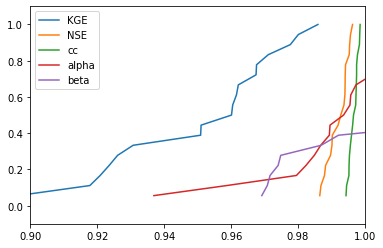

In [74]:
list_1 = ['KGE', 'NSE', 'cc', 'alpha', 'beta']
for met in list_1:
    print(f'{met}_rank')
    df_perf.sort_values(by=f'{met}_rank', inplace=True)
    plt.plot(df_perf[met], df_perf[f'{met}_rank'], label=met)

plt.ylim(-0.1,1.1)
plt.xlim(0.9,1)
plt.legend()
plt.show()

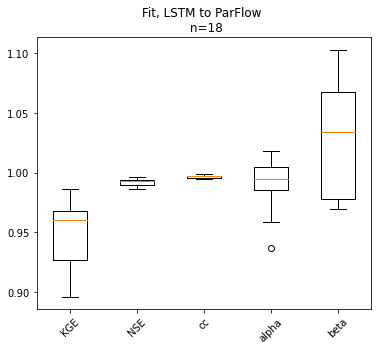

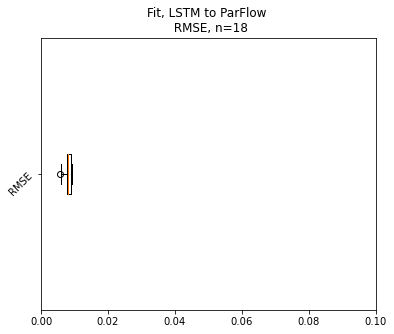

In [75]:
# Create several box plots showing distributions
fig, axs = plt.subplots(figsize=(6,5))

axs.boxplot([df_perf['KGE']  , df_perf['NSE'], df_perf['cc'], 
             df_perf['alpha'], df_perf['beta']])
axs.set_xticklabels(list_1, rotation=45)
plt.title('Fit, LSTM to ParFlow \n n=18')

fig.savefig(f'{save_dir}box_plot_{sub}_runidx_{idx}_ParFlow_LSTM_test.png')
fig.savefig(f'{save_dir}box_plot_{sub}_runidx_{idx}_ParFlow_LSTM_test.eps', format='eps')

plt.show()


fig, axs = plt.subplots(figsize=(6,5))
axs.boxplot(df_perf['RMSE'], vert=False)
axs.set_xlim(0,0.1)
axs.set_yticklabels(['RMSE'], rotation=45)
plt.title('Fit, LSTM to ParFlow \n RMSE, n=18')

fig.savefig(f'{save_dir}box_plot_{sub}_runidx_{idx}_ParFlow_LSTM_test-RMSE.png')
fig.savefig(f'{save_dir}box_plot_{sub}_runidx_{idx}_ParFlow_LSTM_test-RMSE.eps', format='eps')


plt.show()

In [76]:
help(obj_mets.kge)

df_perf.sort_values(by='NSE')

Help on function kge in module spotpy.objectivefunctions:

kge(evaluation, simulation, return_all=False)
    Kling-Gupta Efficiency
    
    Corresponding paper: 
    Gupta, Kling, Yilmaz, Martinez, 2009, Decomposition of the mean squared error and NSE performance criteria: Implications for improving hydrological modelling
    
    output:
        kge: Kling-Gupta Efficiency
    optional_output:
        cc: correlation 
        alpha: ratio of the standard deviation
        beta: ratio of the mean



,K,M,NSE,RMSE,KGE,cc,alpha,beta,NSE_rank,RMSE_rank,KGE_rank,cc_rank,alpha_rank,beta_rank
0,0.968765,0.674743,0.986495,0.008291,0.971115,0.994505,1.013061,0.974829,0.055556,0.611111,0.833333,0.111111,0.888889,0.277778
7,0.968765,0.750000,0.986845,0.007988,0.967607,0.995234,1.008750,0.969177,0.111111,0.388889,0.777778,0.222222,0.833333,0.055556
12,0.849485,0.924743,0.987899,0.008298,0.967461,0.994333,0.986775,0.970814,0.166667,0.666667,0.722222,0.055556,0.333333,0.111111
11,0.718765,0.924743,0.988228,0.009144,0.930743,0.995967,0.936944,0.971642,0.222222,1.000000,0.333333,0.388889,0.055556,0.166667
9,0.750000,0.849485,0.989703,0.008817,0.951042,0.995634,0.958715,0.974050,0.277778,0.777778,0.444444,0.333333,0.111111,0.222222
16,0.968765,0.500000,0.990133,0.007337,0.985937,0.995358,1.002133,0.986898,0.333333,0.222222,1.000000,0.277778,0.722222,0.333333
1,0.599485,0.849485,0.990238,0.008785,0.980088,0.995196,0.982369,0.992092,0.388889,0.722222,0.944444,0.166667,0.222222,0.388889
6,0.500000,0.849485,0.991958,0.008016,0.962157,0.996309,1.017791,1.033195,0.444444,0.444444,0.666667,0.444444,1.000000,0.500000
13,0.750000,0.250000,0.992758,0.008206,0.961600,0.996568,0.995753,1.038009,0.500000,0.555556,0.611111,0.500000,0.611111,0.611111
5,0.349485,0.718765,0.993718,0.008987,0.917822,0.997401,0.989546,1.081469,0.555556,0.888889,0.111111,0.666667,0.444444,0.944444


In [77]:
df_perf.mean()

K             0.621708
M             0.662664
NSE           0.992053
RMSE          0.008019
KGE           0.950647
cc            0.996616
alpha         0.991805
beta          1.025864
NSE_rank      0.527778
RMSE_rank     0.527778
KGE_rank      0.527778
cc_rank       0.527778
alpha_rank    0.527778
beta_rank     0.527778
dtype: float64